In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import decimal
from scipy.stats import norm

Dans ce notebook, nous évaluerons l'évolution de l'imapct I(T) en fonction du nombre de pas   

In [24]:
# Nous ne fixons plus le nombre de pas P

def W_1(n,P):
    W_1 = np.random.randn(n,P)
    W_1[:, 0]= 0
    return W_1

def gen_X(X_0, W,P, delta, n =5, sigma = 8, lbda = 20):
    A = np.full((n,P),0.0)
    A[:,0] = X_0
    for p in range(1,P):
        A[:,p] =A[:,p-1]*np.exp(-lbda*delta) + X_0*(1- np.exp(-lbda*delta))+np.sqrt(delta)*sigma *W[:,p]
    return A

def gen_X_particulier(X_0,N=1, sigma_2 = 1.689):
    return X_0+np.sqrt(sigma_2)*np.random.normal(size = (N,n))

def insolvance_1(E,v, C, R = 0.05):
    assert len(v) == len(C)
    assert E.shape[0] == len(v) and E.shape[1] == len(v)
    used_up = np.full(len(v),False)
    l=-1
    while True:
        used_up+= v<C
        v = (v - (1-R)*np.sum(E*(used_up), axis = 1))*(v>=C)
        if (l == np.sum(used_up)):
            break
        l = np.sum(used_up)
    return used_up

In [25]:
#paramètres du modèles 

N = 100000 
sigma = 8
lbda = 20 
n = 5 


R = 0.05
E = np.array([[0,3,0,0,6],
              [3,0,0,0,0],
              [3,3,0,0,0],
              [2,2,2,0,2],
              [0,2,3,3,0]])

mu = 15. ## commune
c = 10 ## commune
X_0 = np.full(n,mu)
C = np.full(n,c)

In [26]:
#On génère plusieurs trajectoires qui dépendes des pas P

P=365*np.arange(1,20)
P=P.astype(int)
delta = 1 / P
mu = 15
n = 5
num_trials = 10000
X_0=np.full(n*num_trials, mu)
list = [gen_X (X_0, W_1(num_trials*n,p), p, 1/p, n=num_trials*n) for p in P]



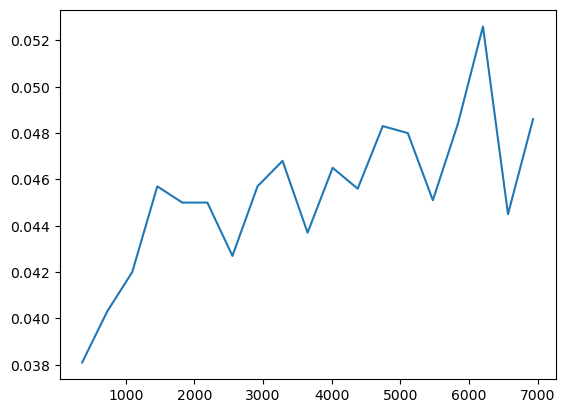

In [27]:

liste_de_matrices = [[A[ i*5:(i+1)*5] for i in range(num_trials)] for A in list ]
def proba_insolvence(i) :
    

    c = 10
    num_trials = 40000
    p=P[i]             # nombre de pas
    X_0 = np.array([15] * 5) 
    W = np.random.randn(5, p) 

    T_c = np.array([np.where(np.any(trial < c, axis=0))[0][0] if np.any(np.any(trial < c, axis=0)) else p for trial in liste_de_matrices[i]])

    non_atteint = len(T_c[T_c == p]) / len(T_c)
    return [1 - non_atteint, T_c]

probas = [ ] # probas d'insolvences en fonction des pas
T_c = [ ]
for i in range (len(P)):
    resultats=proba_insolvence(i)
    T_c.append(resultats[1])
    probas.append(resultats[0])
 
 
plt.plot(P, probas)
        
    
    

In [28]:
liste_de_matrices
listes_impactées = [np.array(liste_de_matrices[i])[T_c[i]<365] for i in range(len(liste_de_matrices))]
indices=[np.where(T_c[i]<365)[0] for i in range(len(T_c))]

In [30]:


def impact_calculate(i,indice):   # i réfère à l'indice dans P, indice l'indice de l'une des matrices ayant pour parametres p
    
    matrix = np.copy(liste_de_matrices[i][indice])
    debut = T_c[i][indice]
    impactées = []  # banques insolvables
    impact = 0.0  # Assurez-vous que total_impact est un flottant
    total=0
    for i in range(debut,P[i]):
        new_impactées_bool = insolvance_1(E, matrix[:, i], C)
        new_impactées = np.where(new_impactées_bool == True)[0]
        
        for j in new_impactées:
            
            if j in impactées:
                continue
            impactées.append(j)
            total=+matrix[j][i]
            # Calcul de l'impact en s'assurant que c'est un flottant
            impact += matrix[j][i] + (1 - R) * np.sum(E[k, j] for k in range(n) if (k not in new_impactées and k not in impactées))
            # Ajustement de la matrice
            matrice_tile = np.tile(E[:, j].reshape(-1, 1), (1, matrix.shape[1]))
            matrix = matrix - (1 - R) * matrice_tile
        
       
     
    return [impact,1*(len(impactées)==5),total]


total_impact = np.full(len(P), 0)
proba_def_total = np.full(len(P), 0)


for i in range(len(P)):
    print(i)
    for indice in indices[i]:
        resultats = impact_calculate(i, indice)
        total_impact[i] += resultats[0]
        proba_def_total[i] += resultats[1]
    
print(" Probas de la défaillance de tout le système :", proba_def_total / num_trials )
print("Impact total :", total_impact / num_trials)



0


/tmp/ipykernel_2404897/835971086.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  impact += matrix[j][i] + (1 - R) * np.sum(E[k, j] for k in range(n) if (k not in new_impactées and k not in impactées))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
 Probas de la défaillance de tout le système : [0.0329 0.0172 0.0134 0.0097 0.0077 0.0055 0.0048 0.0033 0.0024 0.0016
 0.0014 0.0015 0.0015 0.0013 0.0007 0.0006 0.0002 0.0006 0.0006]
Impact total : [1.9602 0.9955 0.7797 0.5722 0.4524 0.3204 0.2807 0.1923 0.1414 0.0952
 0.0859 0.0892 0.0905 0.0707 0.0423 0.034  0.012  0.038  0.0324]


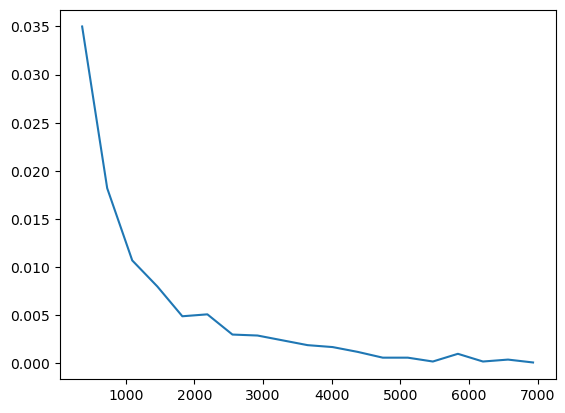

In [ ]:

plt.plot(P,proba_def_total / num_trials)